DALLE2 and imagen are based on DDPMs ( image generation based on text string)

**1.   Forward Process = Adding Noise untill image becomes pure noise**
    

*   In noising the input image x at time t is only depended upon x at t-1 because we perturb each pixel independtly by adding some normally distruted value (same as value from normal distribution)
*   Covariance matrix (between each pixel of noise ) is diagonal and has all equal variance terms beta_t
*   Beta_t is the noise schedular and reduces with time step
*   Higher beta_t more noise added in that time step
*   Ideally, noising process should be smooth (No drastic changes )
*   range in DDPM paper [0.0001, 0.02]
*   Important Property of gaussian distributions, X = mu + sigma*Z, here X will still be a gaussian distribution if Z is the gaussian distribution, This is represnted formally as  "We can sample from gaussian distribution by adding it to the mean vector and a normally distributed noise vector scaled by std deviation"
*   In DDPMs we will have x at t-1 as mu and we can add noise(epsilon) as Z with sqrt(beta) being sigma
*   Other way of represnting the same equation (for noising) is given in the article (see chatgpt cpnversation for proof)
*   As this formula is recurssive, we can connect the final noised timestep to initial input and do noising process (Forward pass) in one step.

**2.   Backward Process = Train a network which can undo the noising steps slowly**

More info needed on Backward process,
The final loss function is minimization between real noise which was added and the predicted by model





In [1]:
!pip3 install einops   #for gifs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


In [2]:
#import libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import einops
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST

import os

#for reproducibility
seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

#definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [3]:
no_train = False
fashion = True #weather to use fashion MNIST or normal MNIST
batch_size = 128
n_epochs = 20
lr = 0.001

In [4]:
store_path = "ddpm_fasion.pt" if fashion else "ddpm_mnist.pt"

**Utility Functions**

In [5]:
def show_images(images, title=""):
  """Shows the given imageds as sub pictures in a square"""

  #Converting the images to CPU numpy arrays
  if type(images) is torch.Tensor:                   # type() is used to check the type images
    images = images.detach().cpu().numpy()           # .detach() detaches images from any computational graph (removes gradient information)
                                                     # .cpu() move tensor from GPU to CPU
                                                     #.numpy() tensor to numpy array

  #define the number of rows and coloumns
  fig = plt.figure(figsize = (8,8))
  rows = int(len(images)**(0.5))
  cols = round(len(images)/rows)


  #Add figures
  idx = 0
  for r in range(rows):
    for c in range(cols):
      fig.add_subplot(rows, cols, idx+1)

      if idx < len(images):
        plt.imshow(images[idx][0], cmap = 'gray')
        idx+=1
  fig.suptitle(title, fontsize = 30)

  plt.show()


def show_first_batch(loader):

  for batch in loader:
    show_images(batch[0], "The first batch")
    break


Loading data

In [6]:
# converting images to tensor and normalizing

transform = Compose([                                    #Compose class is typically used to define pipelines to perfrom data processing (mostly for images)
    ToTensor(),                                          #ToTensor() convert image to pytorch tensor in (Channel, Height, width)
    Lambda(lambda x: (x - 0.5)*2)                         #Custom lambda function: substracts 0.5 from each element and multiplies by 2. To normalize the data between [-1,1]
])
dir = "/content/drive/MyDrive/Colab_Notebooks/Courses/Diffusion_models/"
ds_fn = FashionMNIST if fashion else MNIST
dataset = ds_fn(dir + "/datasets", download=True, train=True, transform=transform)    #when downloading data from torchvision, download=True (download if already not there), train=true(perform train test split), transform (aply the transform pipeline)
loader = DataLoader(dataset, batch_size, shuffle=True)



100%|██████████| 26421880/26421880 [00:02<00:00, 11001292.30it/s]


Extracting /content/drive/MyDrive/Colab_Notebooks/Courses/Diffusion_models//datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab_Notebooks/Courses/Diffusion_models//datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175460.19it/s]


Extracting /content/drive/MyDrive/Colab_Notebooks/Courses/Diffusion_models//datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab_Notebooks/Courses/Diffusion_models//datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3195447.61it/s]


Extracting /content/drive/MyDrive/Colab_Notebooks/Courses/Diffusion_models//datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab_Notebooks/Courses/Diffusion_models//datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10977263.34it/s]

Extracting /content/drive/MyDrive/Colab_Notebooks/Courses/Diffusion_models//datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab_Notebooks/Courses/Diffusion_models//datasets/FashionMNIST/raw



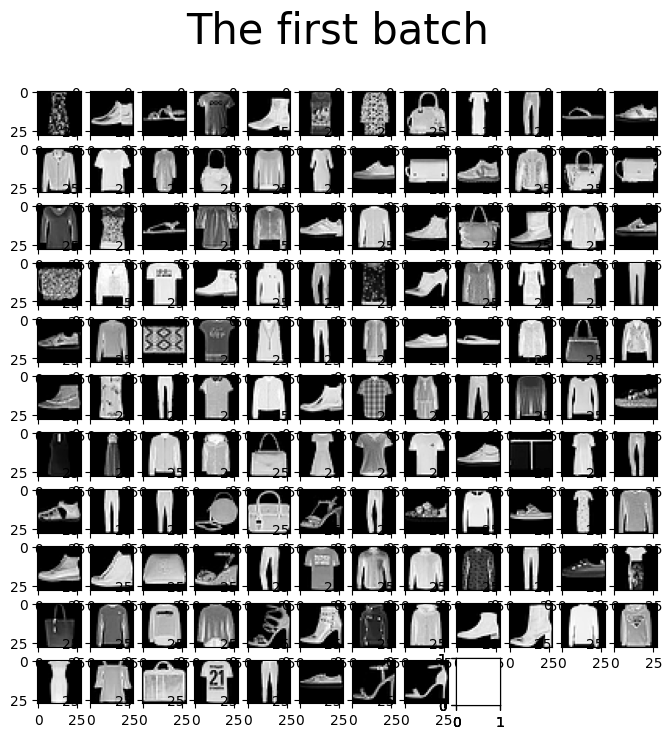

In [7]:
# Optionally, show a batch of regular images
show_first_batch(loader)

In [8]:
#Getting Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"Model name: {torch.cuda.get_device_name(0)}"))

Using device: cuda	Model name: Tesla T4


**Defining DDPM**

The denoising step itself can be implemented using a wide range of neural network architectures, including convolutional neural networks (CNNs), recurrent neural networks (RNNs), feedforward networks, or any other architecture suitable for image or data denoising tasks.

- `n_steps`: number of diffusion steps $T$;
- `min_beta`: value of the first $\beta_t$ ($\beta_1$);
- `max_beta`: value of the last  $\beta_t$ ($\beta_T$);
- `device`: device onto which the model is run;
- `image_chw`: tuple contining dimensionality of images.


The `forward` process of DDPMs benefits from a nice property: We don't actually need to slowly add noise step-by-step, but we can directly skip to whathever step $t$ we want using coefficients $\alpha_bar$.

For the `backward` method instead, we simply let the network do the job.

Note that in this implementation, $t$ is assumed to be a `(N, 1)` tensor, where `N` is the number of images in tensor `x`. We thus support different time-steps for multiple images.

In [9]:
class DDPM(nn.Module):
    def __init__(self, network, n_steps= 200, min_beta = 10**-4, max_beta= 0.02, device=None, image_chw = (1,28,28)):
          super(DDPM, self).__init__()
          self.n_steps = n_steps
          self.device = device
          self.image_chw = image_chw
          self.network = network.to(device)
          self.betas = torch.linspace(min_beta, max_beta, n_steps).to(device)   #schedular for noise addition
          self.alphas = 1 - self.betas
          self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1 ]) for i in range(len(self.alphas))]).to(device)   # list of product of (1-betas) for each time step


    def forward(self, x0, t , eta =None):
          """Noisy image in one step"""

          n, c , h, w = x0.shape
          a_bar =self.alpha_bars[t]

          if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)
          #formula
          noisy = a_bar.sqrt().reshape(n,1,1,1)*x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1)*eta

          return noisy

    def backward(self, x, t):
        #Run each image through the network for each timestep t in the vector t
        #The network returns its estimation of the noise that was added

        return self.network(x, t)



Notice that in the paper (https://arxiv.org/pdf/2006.11239.pdf) by Ho et. al., two options are considered for $\sigma_t^2$:

- $\sigma_t^2$ = $\beta_t$
- $\sigma_t^2$ = $\frac{1 - \bar{\alpha_{t-1}}}{1 - \bar{\alpha_{t}}} \beta_t$

In [10]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    #ddpm is actually the DDPM class which will be fed
    for batch in loader:
        imgs = batch[0]

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images( ddpm(imgs.to(device),
                        [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                         f"DDPM Noisy images {int(percent * 100)}%" )

        break

[see the formula used to predict the mean of noise](https:///content/drive/MyDrive/Colab_Notebooks/Courses/Diffusion_models/Screenshot 2023-10-13 103658.png)

In [11]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=28, w=28):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    """
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    """
    return x

**UNET**

Remember that the only term of the loss function that we really care about is $||\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon, t)||^2$, where $\epsilon$ is some random noise and $\epsilon_\theta$ is the model's prediction of the noise. Now, $\epsilon_\theta$ is a function of both $x$ and $t$ and we don't want to have a distinct model for each denoising step (thousands of independent models), but instead we want to use a single model that takes as input the image $x$ and the scalar value indicating the timestep $t$.

To do so, in practice we use a sinusoidal embedding (function `sinusoidal_embedding`) that maps each time-step to a `time_emb_dim` dimension. These time embeddings are further mapped with some time-embedding MLPs (function `_make_te`) and added to tensors through the network in a channel-wise manner.


In [12]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    #n = number of timesteps
    #d = dimension of embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])   #calculates a set of frequencies for the sinusoidal functions, values that decay exponentially as j increases.
                                                                       #These frequencies are used to generate the sine and cosine components of the embeddings

    wk = wk.reshape((1, d))               #This is done to ensure that wk has the correct shape for later element-wise multiplication with the positional indices.

    t = torch.arange(n).reshape((n, 1))

    embedding[:,::2] = torch.sin(t * wk[:,::2])             # sine components of the embeddings for even-indexed positions
    embedding[:,1::2] = torch.cos(t * wk[:,::2])            #  cosine components of the embeddings for odd-indexed positions

    return embedding

In [13]:
class MyBlock(nn.Module):
  def __init__(self, shape, in_c, out_c, kernel_size = 3, stride=1, padding=1, activation = None, normalize = True):
      super(MyBlock, self).__init__()

      self.ln = nn.LayerNorm(shape)
      self.conv1 = nn.Conv2d(in_c,  out_c, kernel_size, stride, padding)
      self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding )
      self.activation = nn.SiLU() if activation is None else activation
      self.normalize = normalize


  def forward(self, x):
      out = self.ln(x) if self.normalize is True else x
      out = self.conv1(out)
      out = self.activation(out)
      out = self.conv2(out)
      out = self.activation(out)

      return out

    

* weight.data is a pytorch tensor which holds the weight values for a neural
network unlike `weight` or `parameters()`

* This gives direct access to layer's weight and allows to manipulate weights **without tracking gradient computation**
*   This can be useful for various purposes, such as weight initialization, weight clipping, or other non-differentiable operations.

* Be cautious and understand the potential consequences, as these changes won't be part of the backpropagation process during training



In [14]:
class MyUnet(nn.Module):
  def __init__(self, n_steps = 1000, time_emb_dim = 100):
      super(MyUnet, self).__init__()


      self.time_embed = nn.Embedding(n_steps, time_emb_dim)            #starting a instance of nn.embeding of req size
      self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)    #initialize the embedding layer with these positional embeddings
      self.time_embed.requires_grad_(False)

      #down block
      self.te1 = self._make_te(time_emb_dim, 1)              #one embeding at each time step for all the images in dataset
      self.b1  = nn.Sequential(
          MyBlock((1,  28, 28), 1,  10 ),                     #channel depth 1 > 10 > 10
          MyBlock((10, 28, 28), 10, 10 ),
          MyBlock((10, 28, 28), 10, 10 )
      )

      self.down1 = nn.Conv2d(10, 10, 4, 2, 1)                # to downsample from 28 x 28 to 14 x 14

      self.te2 = self._make_te(time_emb_dim, 10)
      self.b2  = nn.Sequential(
          MyBlock((10, 14, 14), 10, 20),
          MyBlock((20, 14, 14), 20, 20),
          MyBlock((20, 14, 14), 20, 20)
      )

      self.down2 = nn.Conv2d(20, 20, 4, 2, 1)


      self.te3 = self._make_te(time_emb_dim, 20)
      self.b3  = nn.Sequential(
          MyBlock((20, 7,  7), 20, 40),
          MyBlock((40, 7,  7), 40, 40),
          MyBlock((40, 7,  7), 40, 40)
      )

      self.down3 = nn.Sequential(
          nn.Conv2d(40, 40, 2, 1),
          nn.SiLU(),
          nn.Conv2d(40, 40, 4, 2, 1)
        )


      # Bottleneck

      self.te_mid = self._make_te(time_emb_dim, 40)
      self.b_mid  = nn.Sequential(
          MyBlock((40, 3, 3), 40, 20),
          MyBlock((20, 3, 3), 20, 20),
          MyBlock((20, 3, 3), 20, 40)
      )

      # Up Block

      self.up1 = nn.Sequential(
          nn.ConvTranspose2d(40, 40, 4, 2, 1),
          nn.SiLU(),
          nn.ConvTranspose2d(40, 40, 2, 1)
        )


      self.te4   = self._make_te(time_emb_dim, 80)
      self.b4 = nn.Sequential(
          MyBlock((80, 7, 7), 80, 40),
          MyBlock((40, 7, 7), 40, 20),
          MyBlock((20, 7, 7), 20, 20)
      )

      self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
      self.te5   = self._make_te(time_emb_dim, 40)
      self.b5  = nn.Sequential(
          MyBlock((40, 14, 14), 40, 20),
          MyBlock((20, 14, 14), 20, 10),
          MyBlock((10, 14, 14), 10, 10)
      )


      self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
      self.te_out = self._make_te(time_emb_dim, 20)
      self.b_out  = nn.Sequential(
          MyBlock((20, 28, 28), 20, 10),
          MyBlock((10, 28, 28), 10, 10),
          MyBlock((10, 28, 28), 10, 10, normalize = False)
      )

      self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)


  def forward(self, x, t):
      # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension (1 channel + 1 embed ))
      t =self.time_embed(t)  # 1 x emb_dim
      n = len(x)             # number of images

      """We are applying time embedding at each Unet stage starting from input image
        Hence shape of time embeding changes evrey time"""

      out1 = self.b1(        x        + self.te1(t).reshape(n, -1, 1, 1))            # (N, 10, 28, 28)
      out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))            # (N, 20, 14, 14)
      out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))            # (N, 40, 7, 7)

      out_mid =self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))    # (N, 40, 3, 3)

      out4 = torch.cat((out3, self.up1(out_mid)), dim=1)                             # (N, 80, 7, 7)
      out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))                        # (N, 20, 7, 7)

      out5 = torch.cat((out2, self.up2(out4)), dim=1)                                # (N, 40, 14, 14)
      out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))                        # (N, 10, 14, 14)

      out = torch.cat((out1, self.up3(out5)), dim=1)                                 # (N, 20, 28, 28)
      out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))                    # (N, 1, 28, 28)

      out = self.conv_out(out)

      return out



  def _make_te(self, dim_in, dim_out):                  #function (MLP) to map each time step to each embedding dim
    return nn.Sequential(
        nn.Linear(dim_in, dim_out),
        nn.SiLU(),
        nn.Linear(dim_out, dim_out))


**Instantiating the model**

In [15]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = DDPM(MyUnet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [16]:
sum([p.numel() for p in ddpm.parameters()])

606852

**Training Loop**

In [17]:
def training_loop(ddpm, loader, n_epochs, optim, device, display= True, store_path="ddpm.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")           #represents positive infinity, which is a special floating-point value that represents a quantity that is larger than any finite number
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc =f"Training proecess", colour="#00ff00"):
        epoch_loss =0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch +1}/{n_epochs}", colour="#005500")):
            #load data

            x0 = batch[0].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            # print(f"eta:{eta.shape}")
            t = torch.randint(0, n_steps, (n,)).to(device)

            #Computing the noisy image based on x0 and teh teimestep (forward step)
            noisy_imgs = ddpm.forward(x0, t, eta)
            # print(f"noisy image:{noisy_imgs.shape}")

            #Getting models estimation of noise based on noisy images and time step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))
            # print(f"eta theta:{eta_theta.shape}")

            #optimizer

            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

          # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)


Training proecess:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

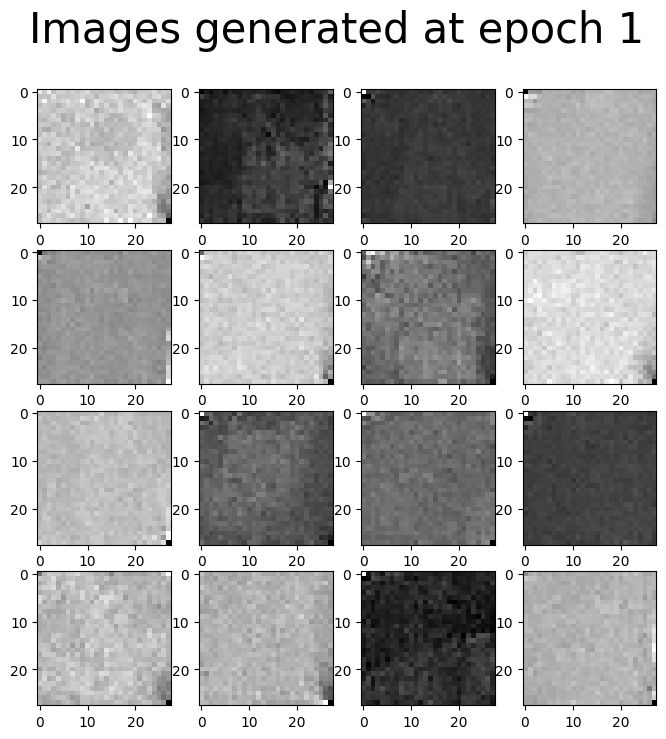

Loss at epoch 1: 0.202 --> Best model ever (stored)


Epoch 2/20:   0%|          | 0/469 [00:00<?, ?it/s]

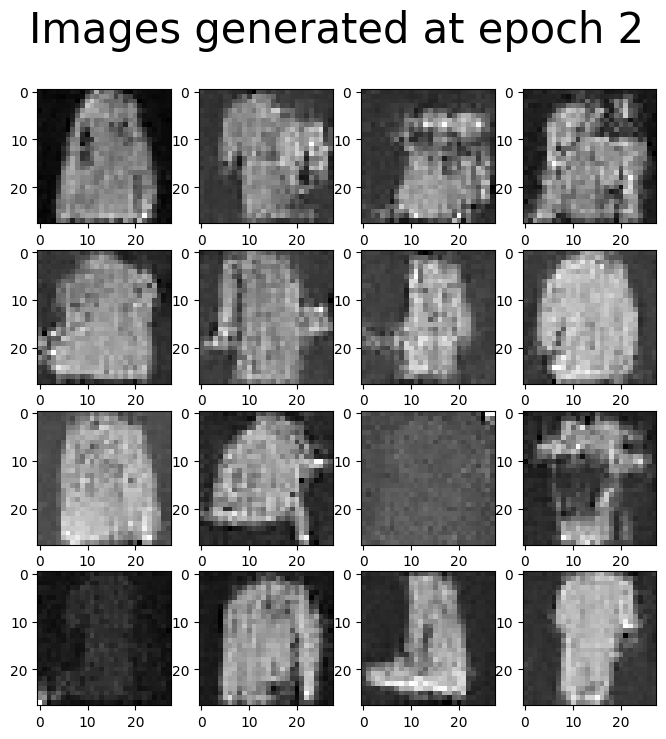

Loss at epoch 2: 0.077 --> Best model ever (stored)


Epoch 3/20:   0%|          | 0/469 [00:00<?, ?it/s]

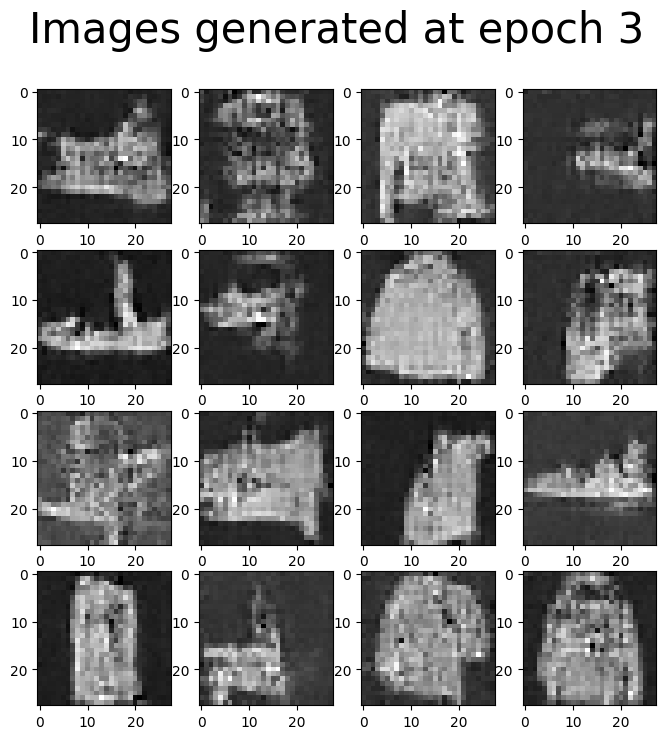

Loss at epoch 3: 0.066 --> Best model ever (stored)


Epoch 4/20:   0%|          | 0/469 [00:00<?, ?it/s]

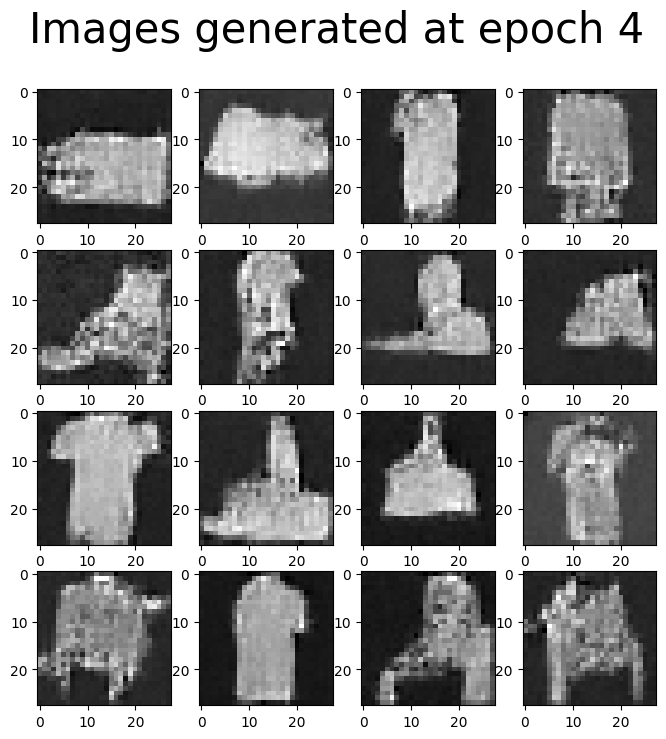

Loss at epoch 4: 0.062 --> Best model ever (stored)


Epoch 5/20:   0%|          | 0/469 [00:00<?, ?it/s]

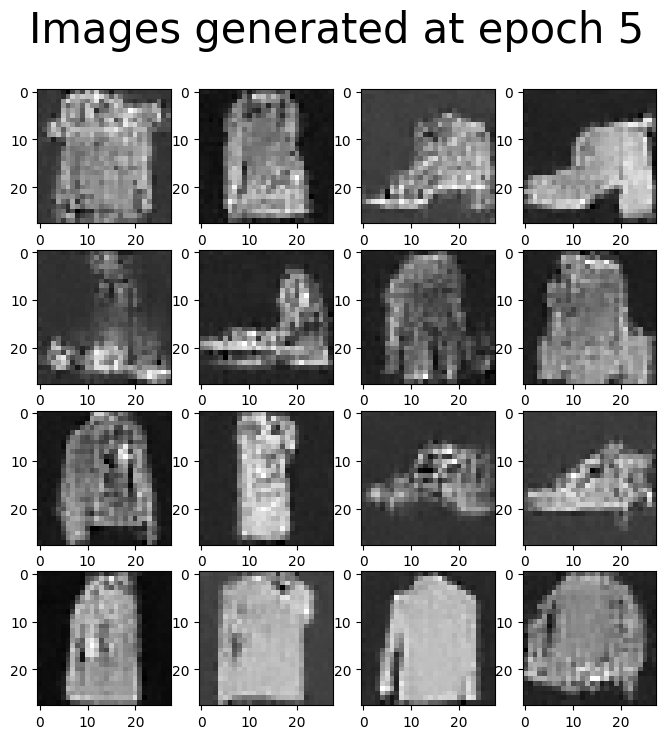

Loss at epoch 5: 0.059 --> Best model ever (stored)


Epoch 6/20:   0%|          | 0/469 [00:00<?, ?it/s]

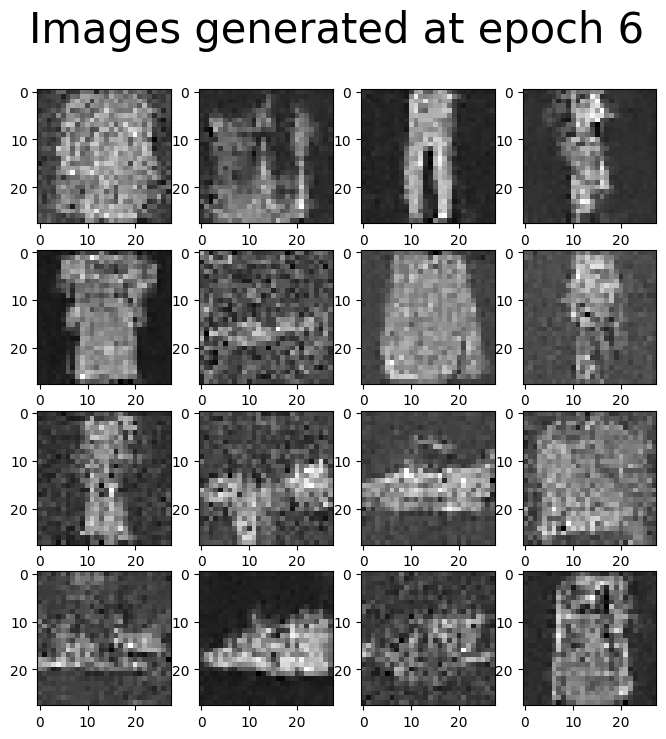

Loss at epoch 6: 0.056 --> Best model ever (stored)


Epoch 7/20:   0%|          | 0/469 [00:00<?, ?it/s]

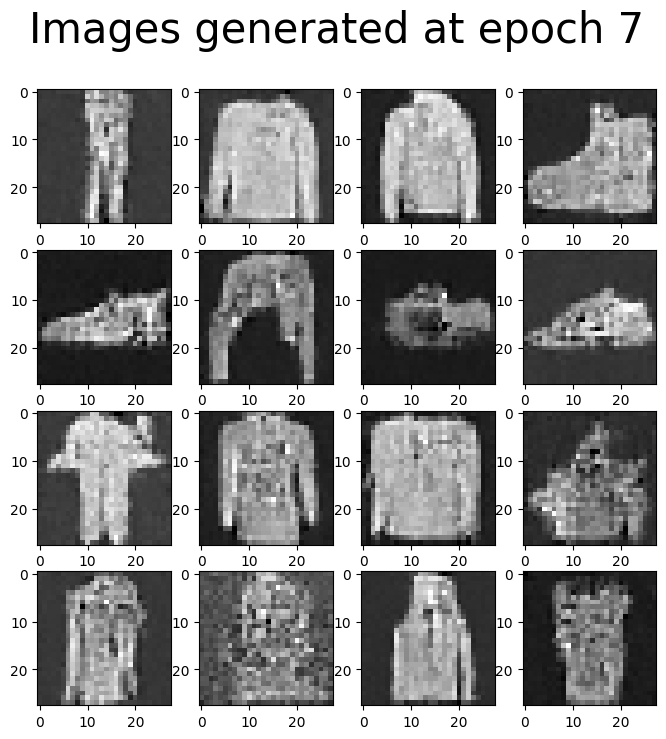

Loss at epoch 7: 0.055 --> Best model ever (stored)


Epoch 8/20:   0%|          | 0/469 [00:00<?, ?it/s]

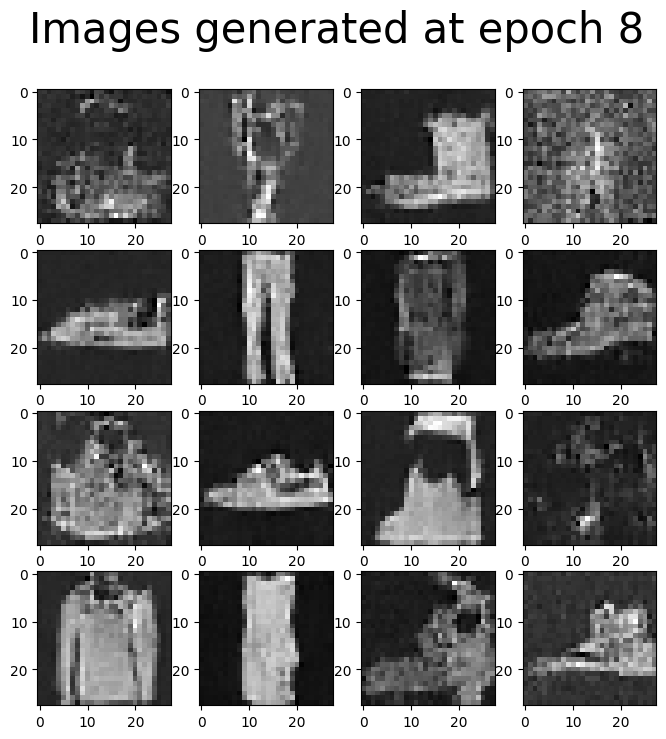

Loss at epoch 8: 0.054 --> Best model ever (stored)


Epoch 9/20:   0%|          | 0/469 [00:00<?, ?it/s]

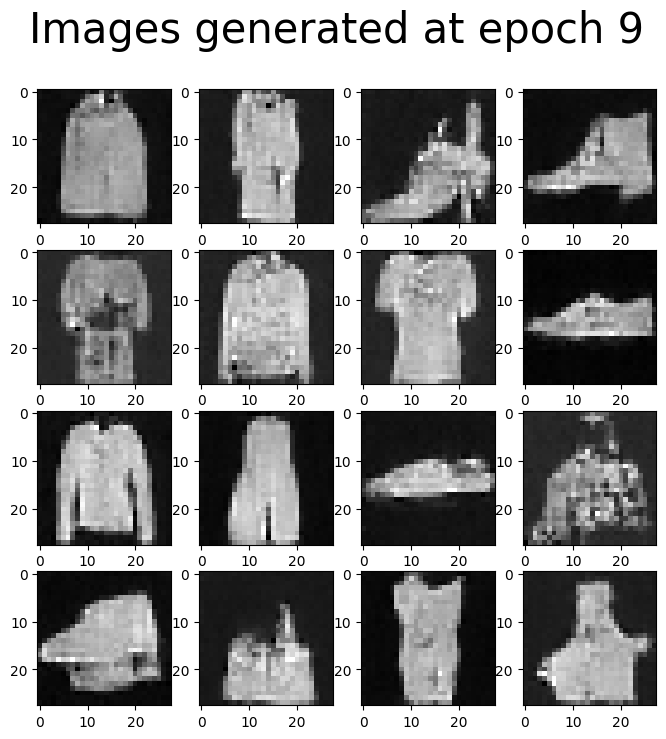

Loss at epoch 9: 0.053 --> Best model ever (stored)


Epoch 10/20:   0%|          | 0/469 [00:00<?, ?it/s]

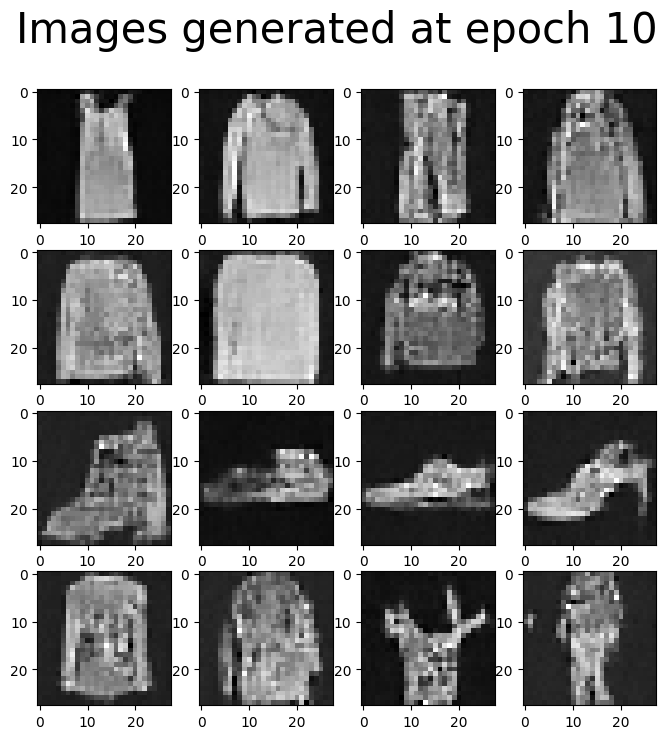

Loss at epoch 10: 0.052 --> Best model ever (stored)


Epoch 11/20:   0%|          | 0/469 [00:00<?, ?it/s]

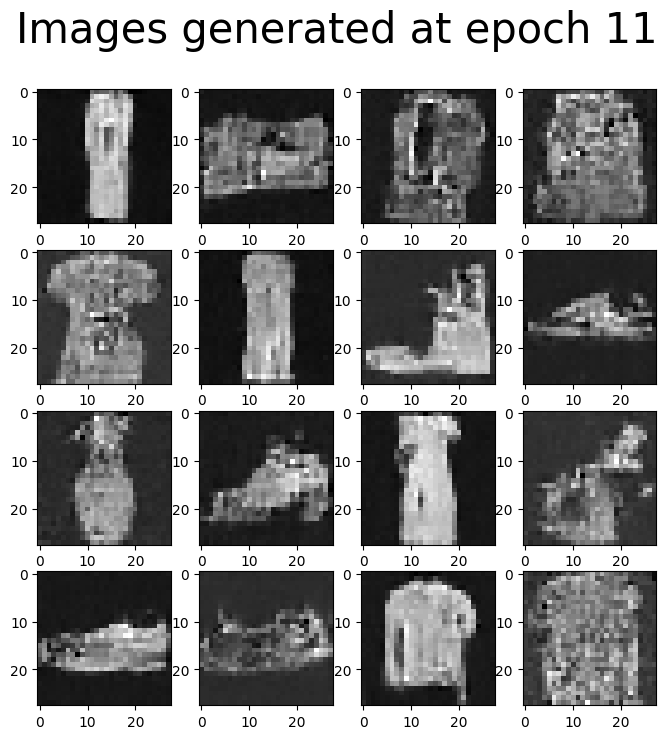

Loss at epoch 11: 0.051 --> Best model ever (stored)


Epoch 12/20:   0%|          | 0/469 [00:00<?, ?it/s]

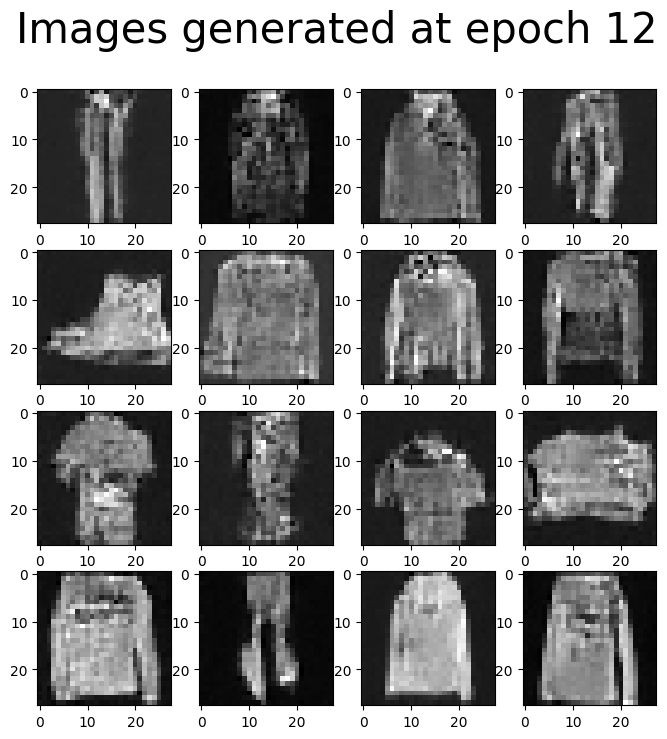

Loss at epoch 12: 0.050 --> Best model ever (stored)


Epoch 13/20:   0%|          | 0/469 [00:00<?, ?it/s]

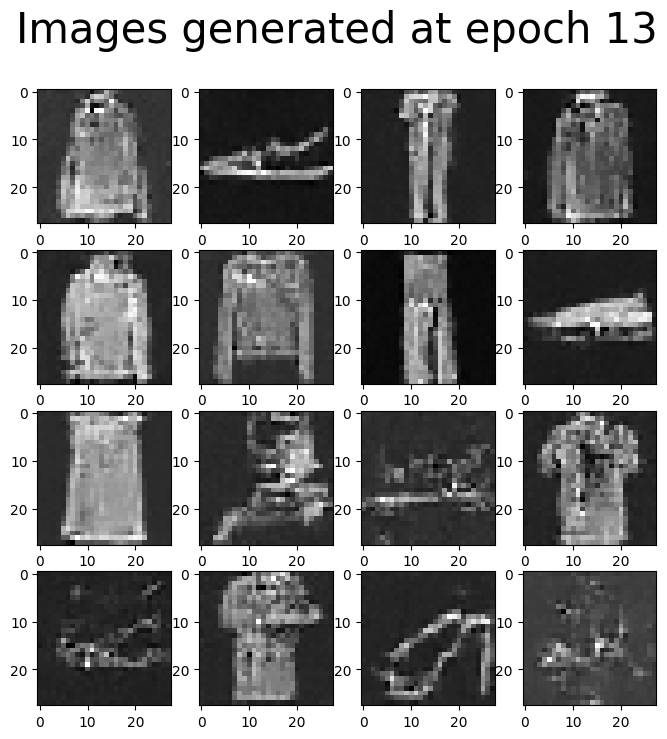

Loss at epoch 13: 0.050


Epoch 14/20:   0%|          | 0/469 [00:00<?, ?it/s]

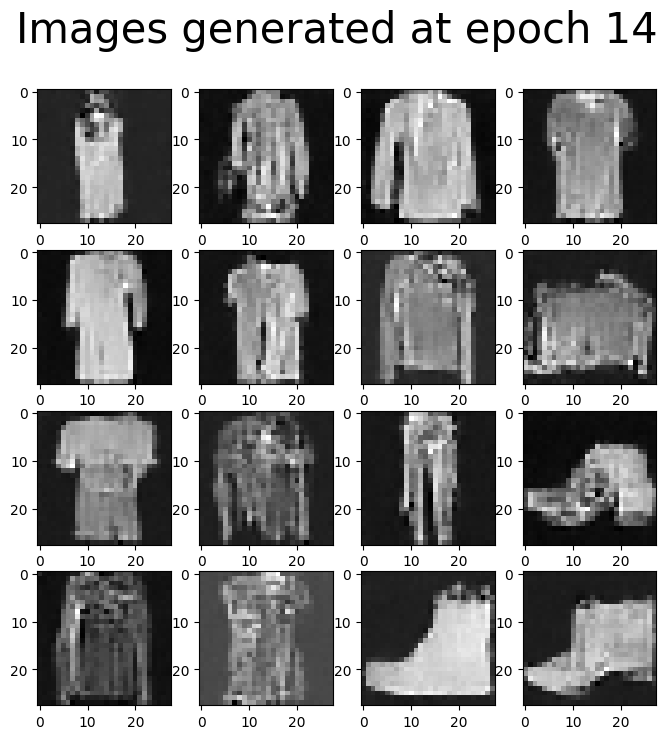

Loss at epoch 14: 0.050 --> Best model ever (stored)


Epoch 15/20:   0%|          | 0/469 [00:00<?, ?it/s]

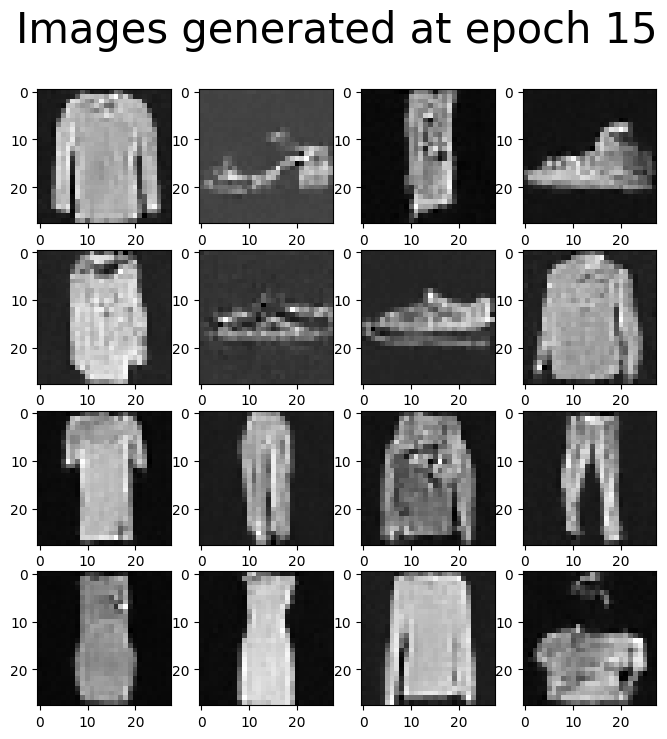

Loss at epoch 15: 0.048 --> Best model ever (stored)


Epoch 16/20:   0%|          | 0/469 [00:00<?, ?it/s]

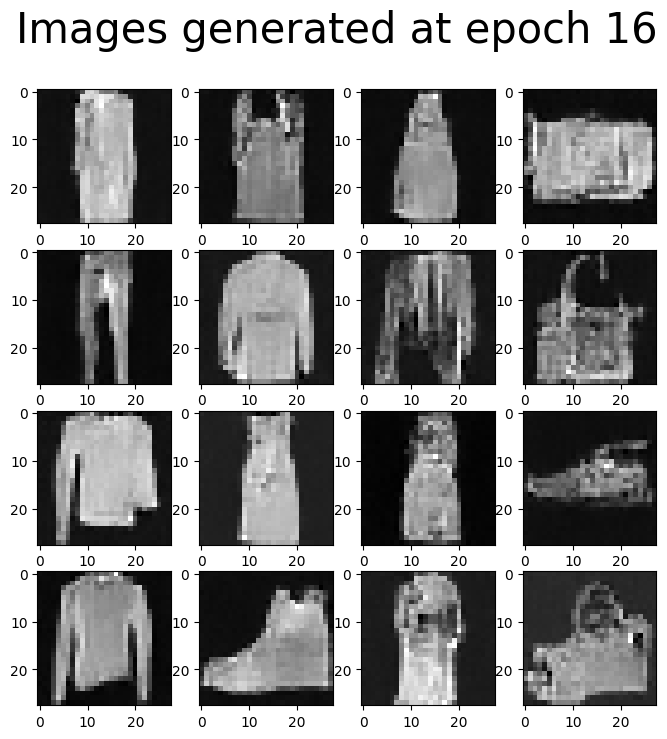

Loss at epoch 16: 0.049


Epoch 17/20:   0%|          | 0/469 [00:00<?, ?it/s]

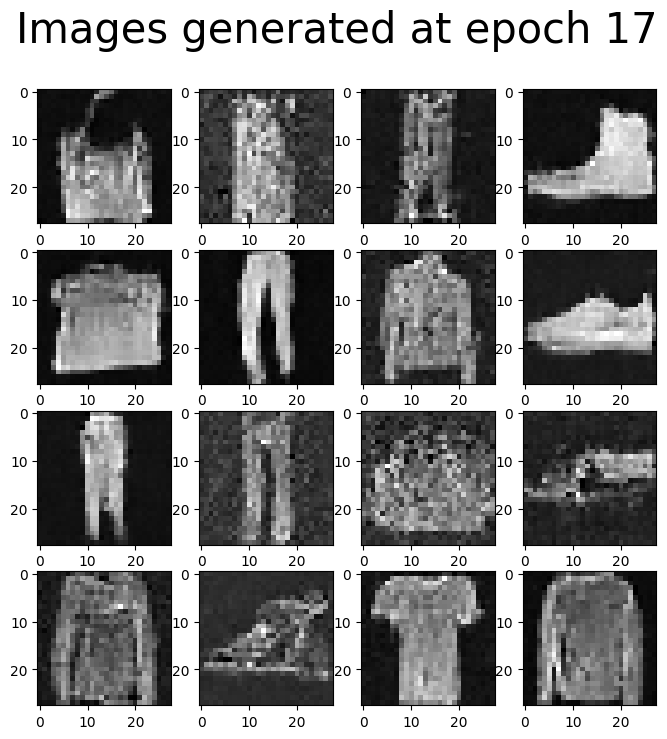

Loss at epoch 17: 0.049


Epoch 18/20:   0%|          | 0/469 [00:00<?, ?it/s]

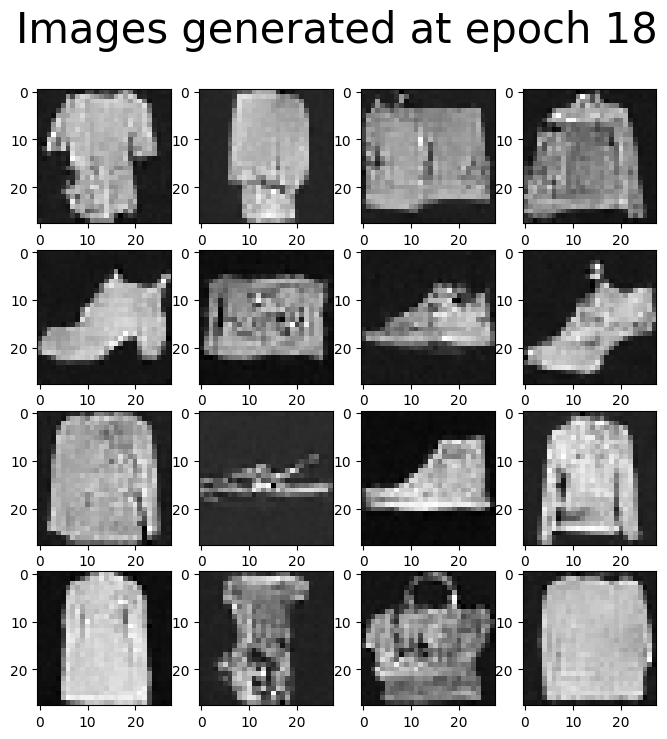

Loss at epoch 18: 0.048 --> Best model ever (stored)


Epoch 19/20:   0%|          | 0/469 [00:00<?, ?it/s]

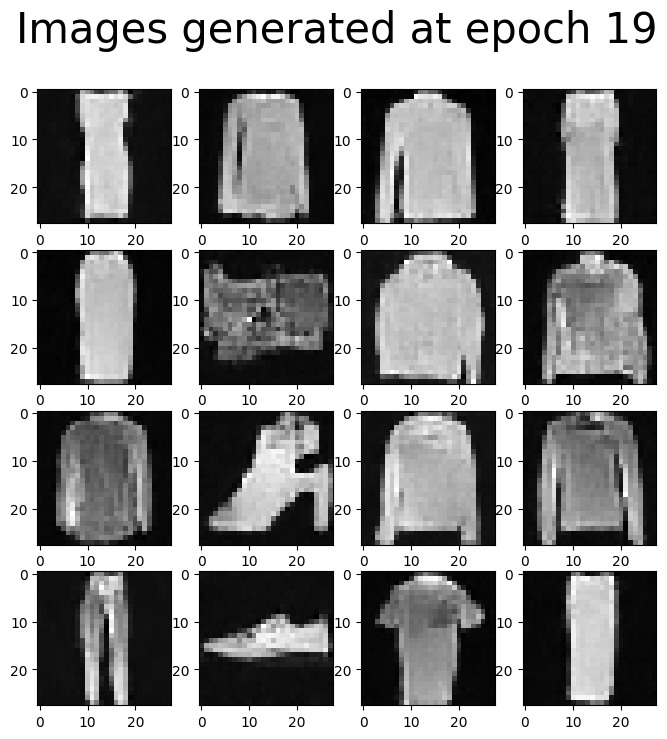

Loss at epoch 19: 0.048


Epoch 20/20:   0%|          | 0/469 [00:00<?, ?it/s]

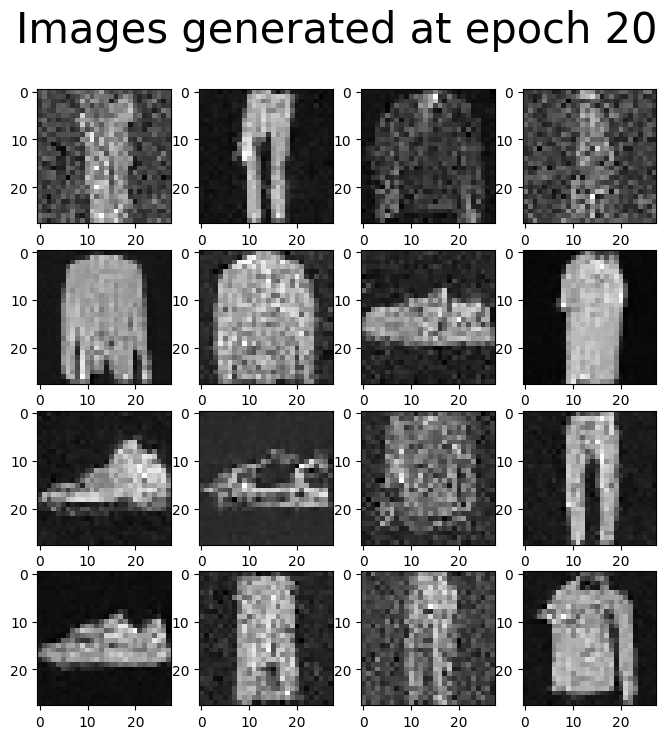

Loss at epoch 20: 0.048 --> Best model ever (stored)


In [18]:
store_path =  "./ddpm_fashion.pt"

if not no_train:
  training_loop(ddpm, loader, n_epochs, optim=Adam(ddpm.parameters(), lr), device = device, store_path= store_path)

Testing

In [19]:
# Loading the trained model
best_model = DDPM(MyUnet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


Generating new images


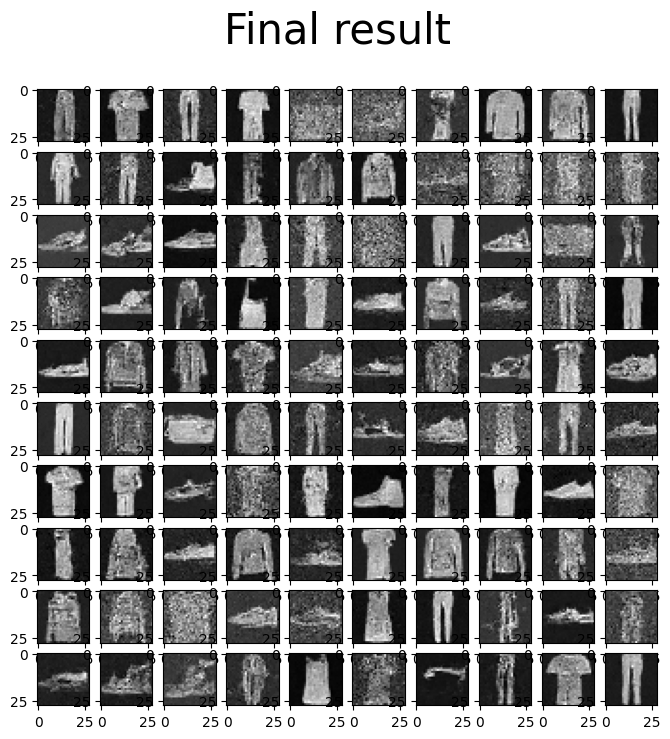

In [21]:
print("Generating new images")
generated = generate_new_images(    #, frames
        best_model,
        n_samples=100,
        device=device,
        gif_name="fashion.gif" if fashion else "mnist.gif"
    )
show_images(generated, "Final result")

In [22]:
frames[0].shape
plt.imshow(frames[0])

NameError: ignored